## Kaggle digit clusterization
Here I will test many approaches to clusterize the MNIST dateset provided by Kaggle. The dataset is formed by a set of 28x28 pixel images. 

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans 
import sklearn.datasets as ds
from sklearn.pipeline import Pipeline
import plotly
from sklearn.decomposition import PCA

from IPython.display import display, clear_output
from __future__ import print_function
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

plotly.offline.init_notebook_mode()

In [7]:
%matplotlib inline

In [6]:
train = pd.read_csv('/mnt/hdfs/sbrouil/mnist/train.csv')
test = pd.read_csv('/mnt/hdfs/sbrouil/mnist/test.csv')

In [8]:
X_train = train.iloc[:,1:].values
Y_train = train.iloc[:,0].values
X_test = test.iloc[:,1:].values

In [43]:
# define some utility function for the rest of the notebook
def plot_d(digit, label):
    plt.axis('off')
    plt.imshow(digit.reshape((28,28)), cmap=plt.cm.gray)
    plt.title(label)

def plot_ds(digits, title, labels):
    n=digits.shape[0]
    n_rows=n/25+1
    n_cols=25
    plt.figure(figsize=(n_cols * 0.9, n_rows * 1.3))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    for i in range(n):
        plt.subplot(n_rows, n_cols, i + 1)
        plot_d(digits[i,:], "%d" % labels[i])
        
def plot_clusters(predict, y, stats):
    for i in range(10):
        indices = np.where(predict == i)
        title = "Most freq item %d, cluster size %d, majority %d " % (stats[i,2], stats[i,1], stats[i,0])
        plot_ds(X_train[indices][:25], title, y[indices])
        
def clusters_stats(predict, y):
    stats = np.zeros((10,3))
    for i in range(10):
        indices = np.where(predict == i)
        cluster = y[indices]
        stats[i,:] = clust_stats(cluster)
    return stats
        
def clust_stats(cluster):
    class_freq = np.zeros(10)
    for i in range(10):
        class_freq[i] = np.count_nonzero(cluster == i)
    most_freq = np.argmax(class_freq)
    n_majority = np.max(class_freq)
    n_all = np.sum(class_freq)
    return (n_majority, n_all, most_freq)
    
def clusters_purity(clusters_stats):
    majority_sum  = clusters_stats[:,0].sum()
    n = clusters_stats[:,1].sum()
    return majority_sum / n

def plot_pca_3d(points, out):
    scatter = {
        'mode':"markers",
        'name': "y",
        'type': "scatter3d",    
        'x': points[:,0], 
        'y': points[:,1], 
        'z': points[:,2],
        'marker': {'size':2, 'color':out, 'colorscale':'Rainbow'}
    }
    fig = {'data':[scatter], 'layout': {'title':"Digits 3 principal components"}}
    py.iplot(fig)

In [12]:
n=100000
n_digits=10
X = X_train[0:n, :]
Y = Y_train[0:n]

### PCA 2 Visualisation of the data
There is no clear cluster but the white points (maybe 0 or 1 digits that can be easily recognized)

In [44]:
import plotly.offline as py

# PCA 2D Visualisation of the data
pca = PCA(n_components=3)
pca_input = X[:1000,:]
X_pca = pca.fit(pca_input).transform(pca_input)
Y_pca = Y[:1000]

plot_pca_3d(X_pca, Y_pca)

### learning from a reduced set of feature using PCA with 10 components
We try to find 10 main components using PCA before clusterize data in 10 clusters using Kmean.

In [45]:
inputs = X[:n,:]

Plotting an extract of the 10 clusters, overall purity: 0.615024


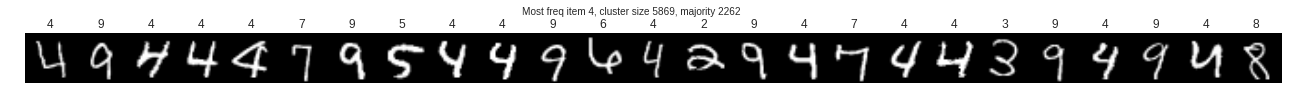

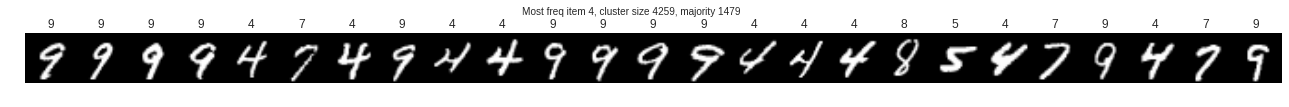

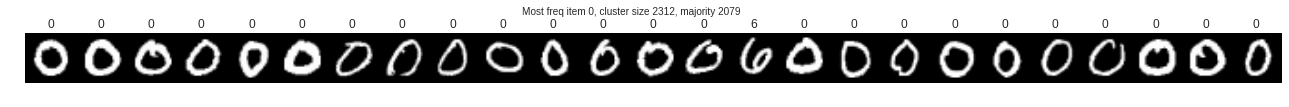

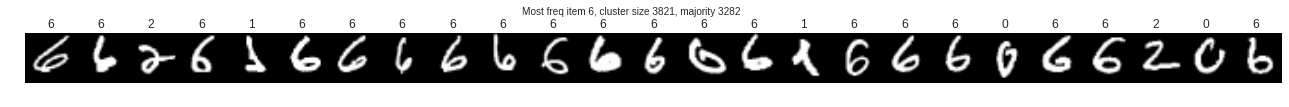

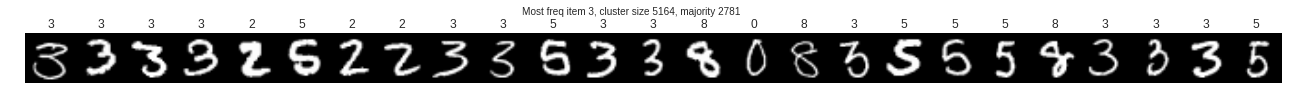

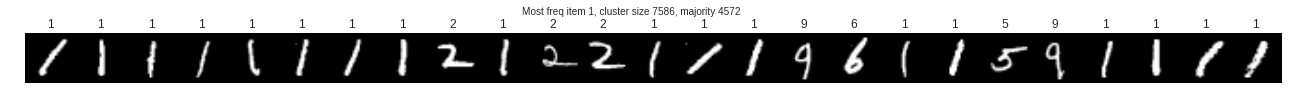

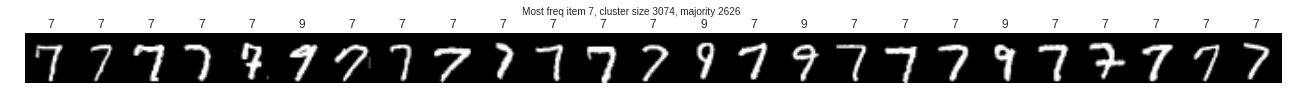

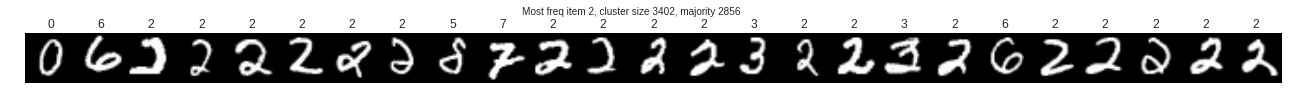

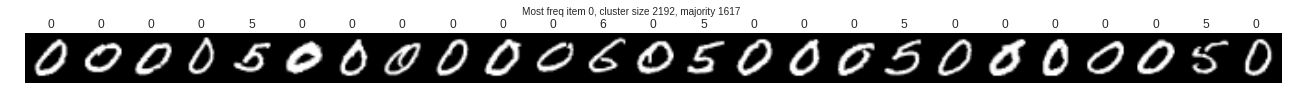

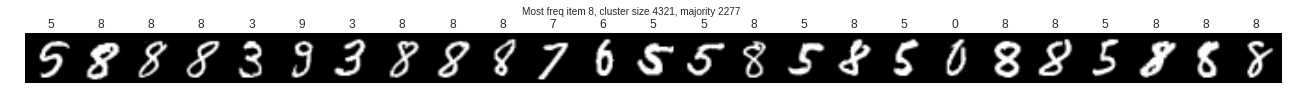

In [47]:
pca = PCA(n_components=n_digits)
kmeans = KMeans(n_clusters=n_digits,n_init=1)
predictor = Pipeline([('pca', pca), ('kmeans', kmeans)])

predict = predictor.fit(inputs).predict(inputs)

stats = clusters_stats(predict, Y)
purity = clusters_purity(stats)

print("Plotting an extract of the 10 clusters, overall purity: %f" % purity)

plot_clusters(predict, Y, stats)

### Using PCA component as centroids init for KMeans

Try to get 10 clusters with KMeans. Clustering with raw pixel as feature space.

In [ ]:
pca = PCA(n_components=n_digits)
X_pca = pca.fit(inputs).transform(inputs)

kmeans = KMeans(n_clusters=n_digits, init=pca.components_, n_init=1)
predict = kmeans.fit(inputs).predict(inputs)

stats = clusters_stats(predict, Y)
purity = clusters_purity(stats)

print("Plotting an extract of the 10 clusters, overall purity: %f" % purity)

plot_clusters(predict, Y, stats)

In [89]:
# result visualization in 2d plot
def visualize(predictor, X, Y):
    reduced = PCA(n_components=2).fit_transform(X)
    predictor.fit(reduced)
    
    plt.figure(figsize=(15, 10))

    # Plot the decision boundary. For that, we will assign a color to each
    h=0.2
    x_min, x_max = reduced[:, 0].min() - 1, reduced[:, 0].max() + 1
    y_min, y_max = reduced[:, 1].min() - 1, reduced[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = predictor.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.imshow(Z, 
       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
       cmap=plt.cm.Paired,
       aspect='auto', origin='lower')

    for i in range(10):
        rows = np.where(Y == i)
        plt.plot(reduced[rows,0], reduced[rows,1], 'k.', marker="$%d$" % i)
        
def visualize_3d(X, Y, predict, cluster_number):
    reduced = PCA(n_components=3).fit_transform(X)
    
    ind = np.where(predict == cluster_number)
    cluster_points = reduced[ind]
    
    scatter = {
        'mode':"markers",
        'name': "y",
        'type': "scatter3d",    
        'x': reduced[:,0], 
        'y': reduced[:,1], 
        'z': reduced[:,2],
        'marker': {'size':2, 'color':Y, 'colorscale':'Rainbow'}
    }
    clusters = {
        'alphahull': 7,
        'name': "y",
        'opacity': 0.08,
        'color': 'CCCCCC',
        'type': "mesh3d",    
        'x': cluster_points[:,0], 
        'y': cluster_points[:,1], 
        'z': cluster_points[:,2],
    }
    fig = {'data':[scatter, clusters], 'layout': {'title':"Digits 3 principal components"}}
    py.iplot(fig)
    
def plot_centroids(kmean):
    centroids = kmean.cluster_centers_
    plt.scatter(centroids[:,0], centroids[:,1], marker='x', color='w', s=100, linewidths=3)

In [93]:
predictor = KMeans(n_clusters=n_digits, init='k-means++')
predict = predictor.fit_predict(X[:1000])

def show_3d_cluster(cluster):
    visualize_3d(X[:1000,:], Y[:1000], predict, cluster)    

interact(show_3d_cluster, cluster=widgets.ToggleButtons(
    description="Clusters",
    options=[0,1,2,3,4,5,6,7,8,9]
))

## Using Bernoulli Restricted Boltzman Machine prior to Kmean
It will try to learn a restricted number of non linear components on the dataset before executing kmeans. The purity has been improved, but there is still a lot of confusion

In [51]:
from sklearn.neural_network import BernoulliRBM

In [52]:
from math import ceil

def plot_rbm_components(components, count):
    plt.figure(figsize=(15, 10))

    for i in range(count):
        comp = components[i]
        ncols = 10
        nrows = ceil(count / ncols)        
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
    plt.suptitle('100 components extracted by RBM', fontsize=16)
    plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [53]:
# scale X cause Bernouilli needs data between 0-1
X_max = np.max(X)
X_min = np.min(X)
X_p = (X - X_min) / X_max

In [ ]:
rbm = BernoulliRBM(n_components=200, random_state=10, verbose=True, n_iter=10)
rbm2 = BernoulliRBM(n_components=50, random_state=10, verbose=True, n_iter=10)
rbm3 = BernoulliRBM(n_components=20, random_state=10, verbose=True, n_iter=10)

rbm.learning_rate = 0.01
rbm.n_iter = 40

kmeans = KMeans(n_clusters=n_digits, init='k-means++')
predictor = Pipeline([('rbm', rbm), ('kmeans', kmeans)])

# 2d visualization
predict = predictor.fit(X_p).predict(X_p)

stats = clusters_stats(predict, Y)
purity = clusters_purity(stats)

print("Plotting an extract of the 10 clusters, overall purity: %f" % purity)
plot_clusters(predict, Y, stats)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -104.37, time = 20.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -90.49, time = 20.52s


In [ ]:
plot_rbm_components(rbm.components_, 100)

**2D PCA View of the components learnt by the RBM on the digits**

In [94]:
X_rbm = rbm.transform(X_p)
pca = PCA(n_components=3)
X_rbm_pca = pca.fit_transform(X_rbm)
plot_pca_3d(X_rbm_pca[:1000], Y[:1000])

## Learning better feature space with autoencoders
We will try to learn a better set of features from the MNIST dataset using supervised learning autoenconders to feed a Kmean algorithm.
On going...

In [ ]:
import theano.tensor as T
from theano import function
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y